# SCC0251 Digital Image Processing

## Assignment 2: Image Enhancement and Filtering

Alexandre Norcia Medeiros - nUSP: 10295583
ICMC / USP - 1o Semester 2020

This notebook shows how the methods were implemented and images examples of its results

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [2]:
def normalize_image(img):
    """ returns a image with its values normalized between [0:255] """
    min_val = np.amin(img)
    max_val = np.amax(img)

    return ( ((img - min_val) * 255) / (max_val - min_val))


def convolution(img, f):
    """ Applies a convolution operation on an image given a filter """

    f_center = int((f.shape[1] - 1) / 2) # shift
    f_flip = np.flip(np.flip(f, 0), 1).astype(np.float) # flip filter to make cross-correlation

    out_img = np.array(img, copy=True)
    img = np.pad(img, pad_width = f_center, mode='constant', constant_values = 0)
    N, M = img.shape
   
    # applies the convolution
    for x in range(f_center, N - f_center):
        for y in range(f_center, M - f_center):
            # get the frame which the filter uses to calculate the new pixel value
            frame = img[x - f_center: x+f_center+1, y-f_center: y+f_center+1]
            
            # alter the image
            out_img[x-f_center][y-f_center] = np.sum(np.multiply(frame, f_flip))

    return out_img


def gaussian_2d(x, y, sigma):
    """ Compute a 2 dimension gaussian function for the given parameters  """

    return  ( 1 / (2 * np.pi  * sigma**2)) * np.exp(-1* (x**2 + y**2) / (2* sigma**2))


def bilateral_filter(img, n, sigma_s, sigma_r):
    """ Applies a bilateral filter in a image """

    img = img.astype(np.float) # conversion to avoid infomation loss due overflow

    # creates the spatial component
    sp_kernel = np.zeros((n,n))
    f_center = int((n-1)/2) # shift
    for i in range(0, n):
        for j in range(0, n):
            sp_kernel[i][j] = gaussian_2d(i - f_center, j - f_center, sigma_s)

    out_img = np.array(img, copy=True)
    img = np.pad(img, pad_width = f_center, mode='constant', constant_values = 0)
    N, M = img.shape
    # applies the convolution computing the range component for each sub frame
    for x in range(f_center, N - f_center):
        for y in range(f_center, M - f_center):
            # get the frame which the filter uses to calculate the new pixel value
            frame = img[x - f_center : x+f_center +1, y-f_center : y+f_center +1]
            p_i = frame[f_center][f_center] # original value of the pixel to be altered
            p_f = 0 # final value of the pixel
            wp = 0 # normalization factor

            for i in range(0, n):
                for j in range(0, n):
                    rng_kernel_element = gaussian_2d( frame[i][j] - p_i, 0, sigma_r)
                    p_f += frame[i][j] * sp_kernel[i][j] * rng_kernel_element
                    wp += sp_kernel[i][j] * rng_kernel_element

            # alter the image
            out_img[x-f_center][y-f_center] = p_f / wp

    return out_img.astype(np.uint8)


def laplacian_kernel(d = 1):
    """ returns one of two discrete approximation of the laplacian kernel """
    if (d == 1):
        r = np.array([
            [0, -1, 0], 
            [-1, 4, -1],
            [0, -1, 0]])
    else:
        r = np.array([
            [-1, -1, -1],
            [-1,  8, -1],
            [-1, -1, -1]])

    return r


def laplacian_filter(img, c, kernel_t):
    """ Applies a laplacian filter in a image using one of two kernels """

    img = img.astype(np.float)# conversion to avoid infomation loss due overflow

    kernel = laplacian_kernel(kernel_t)

    fil_img = convolution(img, kernel) # filtered image
    fil_img = normalize_image(fil_img) # normalize the image in the interval [0:255]
    img = (c * fil_img) + img          # applie the filtered image multiplyed by a constant in the original image
    img = normalize_image(img)         # normalize the final image

    return img.astype(np.uint8)


def vignette_filter(img, sigma_row, sigma_col):
    """ Applies a vignette filter in a image  """

    img = img.astype(np.float) # conversion to avoid infomation loss due overflow
    N, M = img.shape

    row_center = int((N-1)/2)
    col_center = int((M-1)/2)
    # creates row kernel
    row_kernel = np.zeros((N,1))
    for i in range(0,N):
        row_kernel[i][0] = gaussian_2d( i - row_center, 0, sigma_row)
    # creates col
    col_kernel = np.zeros((1, M))
    for i in range(0, M):
        col_kernel[0][i] = gaussian_2d(i - col_center, 0, sigma_col)

    # computes gaussian matrix and applies to image
    out_image = np.multiply( (row_kernel * col_kernel), img)
    out_image = normalize_image(out_image)

    return out_image.astype(np.uint8)

def root_sqr_error(img1, img2):
    """ Calculates the root squared error between two images. """

    dif = img1.astype(np.float) - img2.astype(np.float)

    return np.sqrt(np.sum(np.power(dif, 2)))

## Bilateral filter examples

The bilateral filter purpose is to remove image noise

(-0.5, 149.5, 149.5, -0.5)

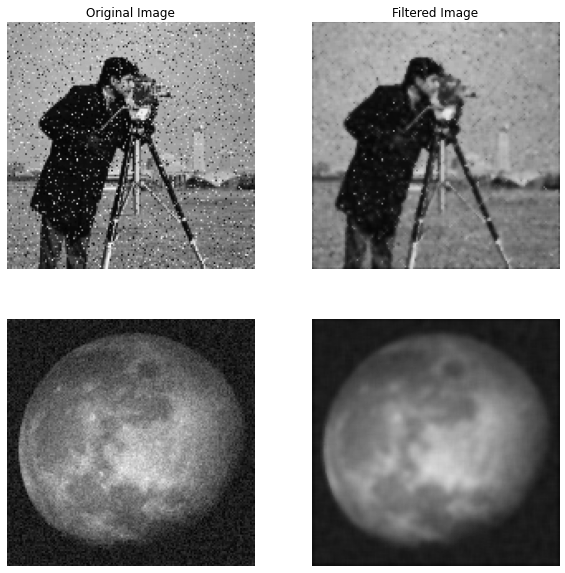

In [3]:
img1 = imageio.imread("images/camera.png")
img2 = imageio.imread("images/moon.png")

# using a filter with size = 3x3, spatial sigma = 150, and range sigma = 100.
out_img1 = bilateral_filter(img1, n = 3, sigma_s = 150.0, sigma_r = 100.0)
# using a filter with size = 5x5, spatial sigma = 50, and range sigma = 100.
out_img2 = bilateral_filter(img2, n = 5, sigma_s = 50.0, sigma_r = 100.0) 

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.title("Original Image")
plt.axis('off')
plt.subplot(222)
plt.imshow(out_img1, cmap="gray", vmin=0, vmax=255)
plt.title("Filtered Image")
plt.axis('off')
plt.subplot(223)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(224)
plt.imshow(out_img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

## Unsharp mask using the Laplacian Filter

This operation purpose is to enhance edges and transitions intensities

(-0.5, 299.5, 299.5, -0.5)

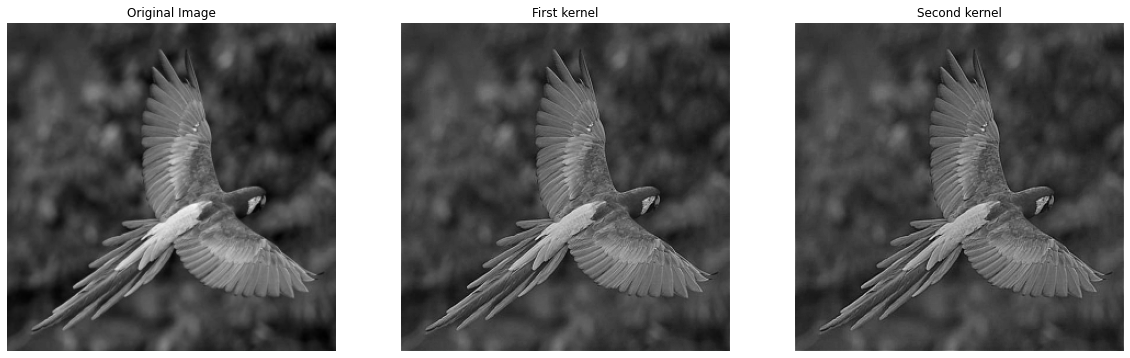

In [4]:
img = imageio.imread("images/arara.png")

out_img1 = laplacian_filter(img, c = 0.5, kernel_t = 1) # Operation using the first Kernel approximation
out_img2 = laplacian_filter(img, c = 0.7, kernel_t = 2) # Operation using the second Kernel approximation c= 0.7


plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.title("Original Image")
plt.axis('off')
plt.subplot(132)
plt.imshow(out_img1, cmap="gray", vmin=0, vmax=255)
plt.title("First kernel")
plt.axis('off')
plt.subplot(133)
plt.imshow(out_img2, cmap="gray", vmin=0, vmax=255)
plt.title("Second kernel")
plt.axis('off')

## Vignette Filter

Its purpose it to remove brightness from the corners

(-0.5, 249.5, 249.5, -0.5)

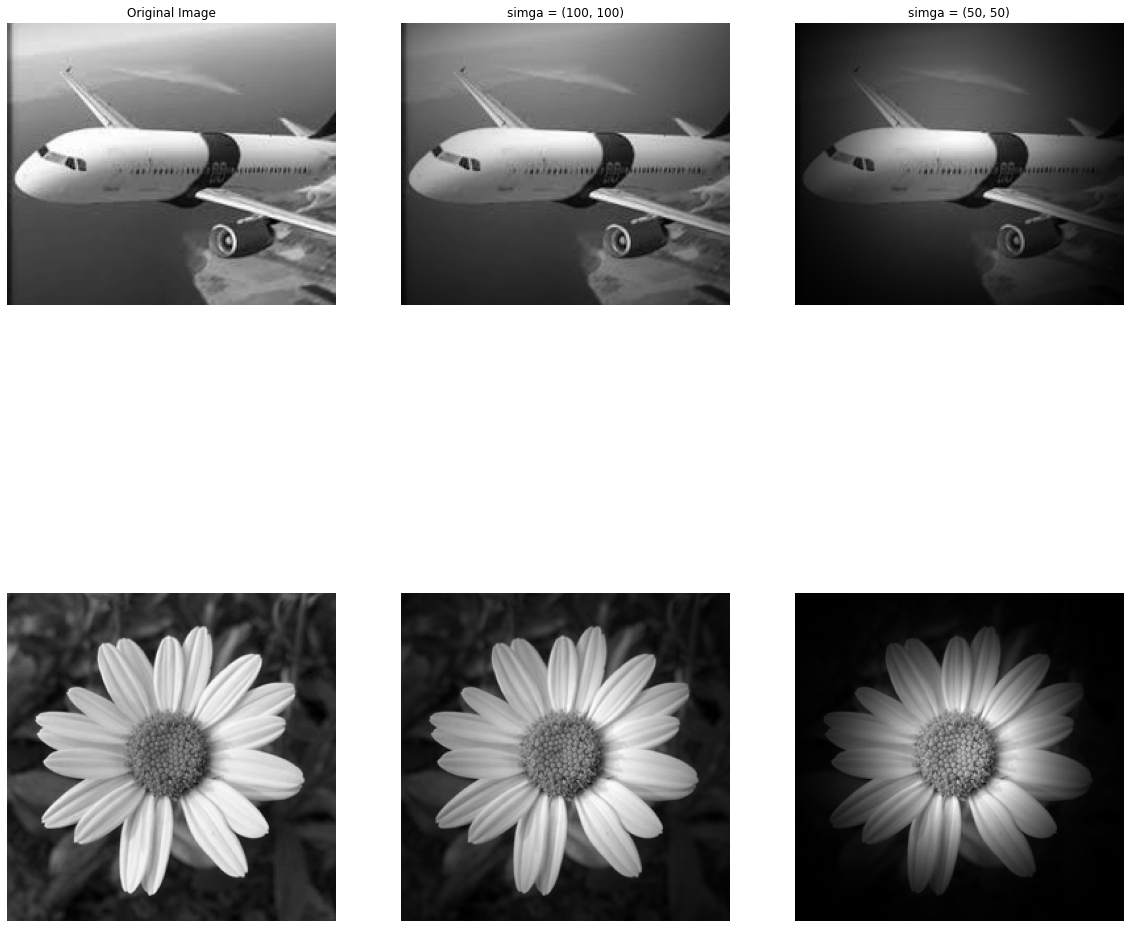

In [5]:
img1 = imageio.imread("images/airplane.png")
img2 = imageio.imread("images/flower.png")

# airplane
out_img1 = vignette_filter(img1, sigma_row = 100, sigma_col = 100)
out_img2 = vignette_filter(img1, sigma_row = 50, sigma_col = 50)
# flower
out_img3 = vignette_filter(img2, sigma_row = 100, sigma_col = 100)
out_img4 = vignette_filter(img2, sigma_row = 50, sigma_col = 50)

# plot
plt.figure(figsize=(20, 20))
plt.subplot(231)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.title("Original Image")
plt.axis('off')
plt.subplot(232)
plt.imshow(out_img1, cmap="gray", vmin=0, vmax=255)
plt.title("simga = (100, 100)")
plt.axis('off')
plt.subplot(233)
plt.imshow(out_img2, cmap="gray", vmin=0, vmax=255)
plt.title("simga = (50, 50)")
plt.axis('off')
plt.subplot(234)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(235)
plt.imshow(out_img3, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(236)
plt.imshow(out_img4, cmap="gray", vmin=0, vmax=255)
plt.axis('off')